### SetUp

In [1]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Sigmoid, Dropout
from train import _compute_metrics, train_epoch, eval_epoch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
project_path = Path(Path.cwd()).parent.parent

In [3]:
SEED = 7777

### Load Data

In [4]:
cancer_detection_path = project_path / "data/inputs/Lung Cancer Dataset.csv"
df_detection = pd.read_csv(cancer_detection_path)

df_detection.columns = [x for x in df_detection.columns.str.lower().str.replace(" ", "_")]

df_detection.head(10)

,age,gender,smoking,finger_discoloration,mental_stress,exposure_to_pollution,long_term_illness,energy_level,immune_weakness,breathing_issue,alcohol_consumption,throat_discomfort,oxygen_saturation,chest_tightness,family_history,smoking_family_history,stress_immune,pulmonary_disease
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES
5,37,1,1,1,1,1,1,57.684285,0,1,1,1,94.057151,1,0,0,0,YES
6,50,0,1,1,1,0,1,52.647022,1,1,1,0,96.773598,0,0,0,1,NO
7,68,0,1,1,1,0,1,53.306451,0,0,0,1,95.019018,0,0,0,0,NO
8,48,0,1,1,0,1,1,64.272789,1,1,0,1,98.539379,1,0,0,0,YES
9,52,0,0,0,1,1,1,58.319319,0,1,0,1,96.055097,0,0,0,0,NO


In [5]:
df_detection.shape

(5000, 18)

### Preprocessing

In [6]:
# Convert label column to numerical values
label_map_dict = {
    'NO': 0,
    'YES': 1
}

df_detection['pulmonary_disease'] = df_detection['pulmonary_disease'].map(label_map_dict)

In [7]:
# Convert binary columns to categorical
binary_columns = [
    'gender',
    'smoking',
    'finger_discoloration',
    'mental_stress',
    'exposure_to_pollution',
    'long_term_illness',
    'immune_weakness',
    'breathing_issue',
    'alcohol_consumption',
    'throat_discomfort',
    'chest_tightness',
    'family_history',
    'smoking_family_history',
    'stress_immune',
    'pulmonary_disease'
]

df_detection[binary_columns] = df_detection[binary_columns].astype('category')

In [8]:
X = df_detection.drop(columns=['pulmonary_disease']).values
y = df_detection['pulmonary_disease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train)

In [9]:
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (3612, 17)
Validation set shape: (638, 17)
Test set shape: (750, 17)


In [10]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([57.37015504,  0.49612403,  0.66196013,  0.60354374,  0.54512735,
         0.51522702,  0.43992248, 54.99256295,  0.39451827,  0.79983389,
         0.35022148,  0.69988926, 94.9913959 ,  0.6013289 ,  0.303433  ,
         0.20265781,  0.21179402]),
 array([15.83079571,  0.49998498,  0.47304219,  0.48916121,  0.49795936,
         0.49976808,  0.49637757,  7.84740972,  0.48874697,  0.40012453,
         0.4770392 ,  0.45830589,  1.49321387,  0.48962481,  0.4597406 ,
         0.40197963,  0.40857963]))

In [11]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([-9.36712256e-17,  5.58799961e-16,  2.21921657e-17,  9.18731069e-16,
         3.39583167e-16, -3.29501407e-16, -3.01223301e-18,  6.65107197e-15,
        -5.77365152e-16, -2.30528037e-18, -2.22474924e-16,  1.03645405e-16,
         8.44649655e-14, -1.71082540e-16,  2.00467181e-16,  4.21036406e-16,
        -5.33165243e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

### Final Model

Epoch   1/300 | Train: Loss 0.6829 Acc 58.94% F1 0.0725 AUROC 0.5496 | Val: Loss 0.6730 Acc 59.25% F1 0.0000 AUROC 0.8780
Epoch  10/300 | Train: Loss 0.3543 Acc 87.90% F1 0.8505 AUROC 0.9164 | Val: Loss 0.2858 Acc 91.22% F1 0.8943 AUROC 0.9426
Epoch  20/300 | Train: Loss 0.3359 Acc 89.29% F1 0.8684 AUROC 0.9219 | Val: Loss 0.2712 Acc 92.32% F1 0.9074 AUROC 0.9430
Epoch  30/300 | Train: Loss 0.3167 Acc 89.15% F1 0.8651 AUROC 0.9275 | Val: Loss 0.2584 Acc 92.63% F1 0.9105 AUROC 0.9431
Epoch  40/300 | Train: Loss 0.2972 Acc 90.73% F1 0.8856 AUROC 0.9310 | Val: Loss 0.2509 Acc 92.48% F1 0.9080 AUROC 0.9434
Epoch  50/300 | Train: Loss 0.2968 Acc 90.42% F1 0.8823 AUROC 0.9315 | Val: Loss 0.2439 Acc 93.42% F1 0.9195 AUROC 0.9454
Epoch  60/300 | Train: Loss 0.2923 Acc 90.84% F1 0.8870 AUROC 0.9327 | Val: Loss 0.2416 Acc 92.95% F1 0.9133 AUROC 0.9456
Epoch  70/300 | Train: Loss 0.2851 Acc 91.03% F1 0.8891 AUROC 0.9341 | Val: Loss 0.2397 Acc 93.10% F1 0.9154 AUROC 0.9444
Epoch  80/300 | Train: L

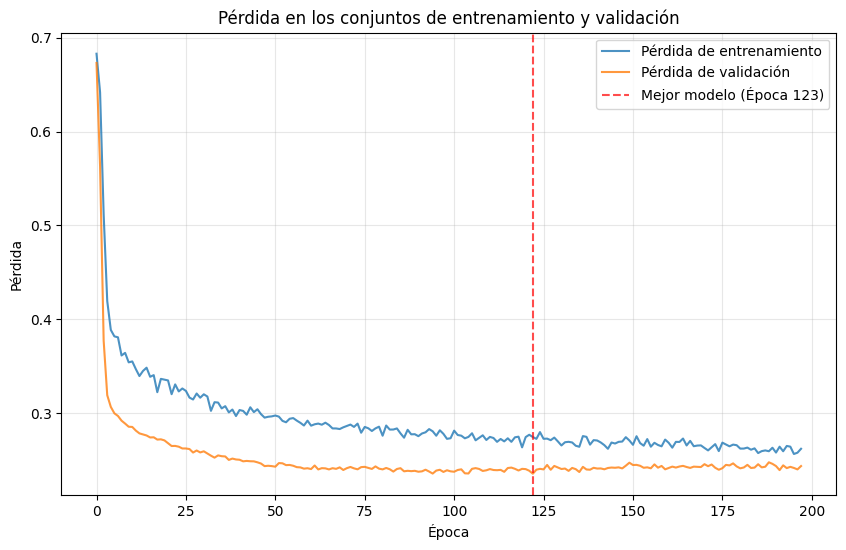

In [39]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

mlp = Sequential(
    Linear(17, 64),
    ReLU(),
    Dropout(0.4),
    Linear(64, 32),
    ReLU(),
    Dropout(0.4),
    Linear(32, 16),
    ReLU(),
    Dropout(0.1),
    Linear(16, 2)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0005, weight_decay=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

# Training loop
epochs = 300
mlp.to(device)

# Early stopping variables
best_val_loss = float('inf')
patience = 75
patience_counter = 0
best_epoch = 0

# History tracking
history_loss_train = []
history_loss_val = []

# Best model metrics storage
best_train_metrics = {}
best_val_metrics = {}

for epoch in range(epochs):
    train_loss, train_acc, train_labels, train_preds, train_probs = train_epoch(mlp, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_labels, val_preds, val_probs = eval_epoch(mlp, val_loader, criterion, device)
    
    # Store loss history
    history_loss_train.append(train_loss)
    history_loss_val.append(val_loss)
    
    # Compute detailed metrics
    train_precision, train_recall, train_f1, train_auroc = _compute_metrics(train_labels, train_preds, train_probs)
    val_precision, val_recall, val_f1, val_auroc = _compute_metrics(val_labels, val_preds, val_probs)
    
    # Print metrics every 10 epochs or at the end
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: Loss {train_loss:.4f} Acc {train_acc:.2f}% F1 {train_f1:.4f} AUROC {train_auroc:.4f} | Val: Loss {val_loss:.4f} Acc {val_acc:.2f}% F1 {val_f1:.4f} AUROC {val_auroc:.4f}")
    
    # Early stopping and best model tracking
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        
        # Save best model
        torch.save(mlp.state_dict(), 'best_model.pth')
        
        # Store best model metrics
        best_train_metrics = {
            'loss': train_loss,
            'accuracy': train_acc,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'auroc': train_auroc
        }
        
        best_val_metrics = {
            'loss': val_loss,
            'accuracy': val_acc,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auroc': val_auroc
        }
        
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Print best model performance during training/validation
print(f"\n{'='*80}")
print(f"MEJOR DESEMPEÑO DEL MODELO (Época {best_epoch}):")
print(f"{'='*80}")
print(f"Entrenamiento - Pérdida: {best_train_metrics['loss']:.4f}, Accuracy: {best_train_metrics['accuracy']:.2f}%, "
      f"Precision: {best_train_metrics['precision']:.4f}, Recall: {best_train_metrics['recall']:.4f}, "
      f"F1: {best_train_metrics['f1']:.4f}, AUROC: {best_train_metrics['auroc']:.4f}")
print(f"Validación   - Pérdida: {best_val_metrics['loss']:.4f}, Accuracy: {best_val_metrics['accuracy']:.2f}%, "
      f"Precision: {best_val_metrics['precision']:.4f}, Recall: {best_val_metrics['recall']:.4f}, "
      f"F1: {best_val_metrics['f1']:.4f}, AUROC: {best_val_metrics['auroc']:.4f}")

# Load best model and evaluate on test set
mlp.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_labels, test_preds, test_probs = eval_epoch(mlp, test_loader, criterion, device)
test_precision, test_recall, test_f1, test_auroc = _compute_metrics(test_labels, test_preds, test_probs)

print(f"\nRESULTADOS DEL CONJUNTO DE PRUEBA (usando el mejor modelo):")
print(f"Pérdida: {test_loss:.4f}, Accuracy: {test_acc:.2f}%, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUROC: {test_auroc:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(history_loss_train, label='Pérdida de entrenamiento', alpha=0.8)
plt.plot(history_loss_val, label='Pérdida de validación', alpha=0.8)
plt.axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.7, label=f'Mejor modelo (Época {best_epoch})')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida en los conjuntos de entrenamiento y validación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [40]:
from torchinfo import summary
summary(mlp, input_size=(1, 17))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Linear: 1-1                            [1, 64]                   1,152
├─ReLU: 1-2                              [1, 64]                   --
├─Dropout: 1-3                           [1, 64]                   --
├─Linear: 1-4                            [1, 32]                   2,080
├─ReLU: 1-5                              [1, 32]                   --
├─Dropout: 1-6                           [1, 32]                   --
├─Linear: 1-7                            [1, 16]                   528
├─ReLU: 1-8                              [1, 16]                   --
├─Dropout: 1-9                           [1, 16]                   --
├─Linear: 1-10                           [1, 2]                    34
Total params: 3,794
Trainable params: 3,794
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward p

### Base model without overfitting-reduction strategies

Epoch   1/300 | Train: Loss 0.6229 Acc 63.26% F1 0.3388 AUROC 0.7254 | Val: Loss 0.5125 Acc 73.67% F1 0.5714 AUROC 0.8970
Epoch  10/300 | Train: Loss 0.2964 Acc 90.59% F1 0.8840 AUROC 0.9313 | Val: Loss 0.2662 Acc 92.01% F1 0.9040 AUROC 0.9447
Epoch  20/300 | Train: Loss 0.2558 Acc 91.83% F1 0.8993 AUROC 0.9499 | Val: Loss 0.2540 Acc 91.69% F1 0.8990 AUROC 0.9458
Epoch  30/300 | Train: Loss 0.2248 Acc 92.52% F1 0.9077 AUROC 0.9646 | Val: Loss 0.2587 Acc 92.32% F1 0.9060 AUROC 0.9433
Epoch  40/300 | Train: Loss 0.1923 Acc 93.16% F1 0.9154 AUROC 0.9756 | Val: Loss 0.2836 Acc 92.16% F1 0.9031 AUROC 0.9366
Epoch  50/300 | Train: Loss 0.1604 Acc 93.99% F1 0.9259 AUROC 0.9837 | Val: Loss 0.3198 Acc 90.91% F1 0.8872 AUROC 0.9321
Epoch  60/300 | Train: Loss 0.1308 Acc 94.82% F1 0.9361 AUROC 0.9897 | Val: Loss 0.3534 Acc 91.38% F1 0.8940 AUROC 0.9319
Epoch  70/300 | Train: Loss 0.0968 Acc 96.35% F1 0.9551 AUROC 0.9949 | Val: Loss 0.4105 Acc 89.03% F1 0.8633 AUROC 0.9244
Epoch  80/300 | Train: L

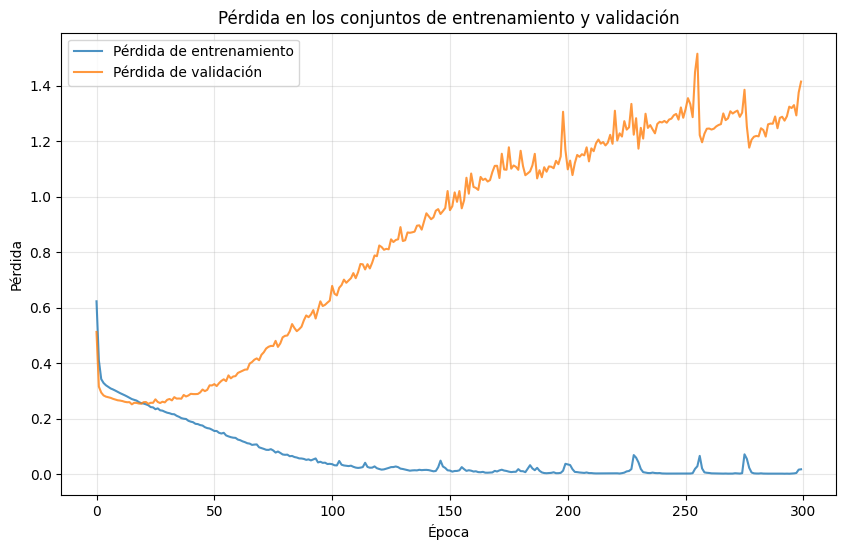

In [13]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

mlp = Sequential(
    Linear(17, 64),
    LeakyReLU(),
    Linear(64, 64),
    LeakyReLU(),
    Linear(64, 64),
    LeakyReLU(),
    Linear(64, 2)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0005, weight_decay=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

# Training loop
epochs = 300
mlp.to(device)

# Early stopping variables
best_val_loss = float('inf')
patience = 300
patience_counter = 0
best_epoch = 0

# History tracking
history_loss_train = []
history_loss_val = []

# Best model metrics storage
best_train_metrics = {}
best_val_metrics = {}

for epoch in range(epochs):
    train_loss, train_acc, train_labels, train_preds, train_probs = train_epoch(mlp, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_labels, val_preds, val_probs = eval_epoch(mlp, val_loader, criterion, device)
    
    # Store loss history
    history_loss_train.append(train_loss)
    history_loss_val.append(val_loss)
    
    # Compute detailed metrics
    train_precision, train_recall, train_f1, train_auroc = _compute_metrics(train_labels, train_preds, train_probs)
    val_precision, val_recall, val_f1, val_auroc = _compute_metrics(val_labels, val_preds, val_probs)
    
    # Print metrics every 10 epochs or at the end
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: Loss {train_loss:.4f} Acc {train_acc:.2f}% F1 {train_f1:.4f} AUROC {train_auroc:.4f} | Val: Loss {val_loss:.4f} Acc {val_acc:.2f}% F1 {val_f1:.4f} AUROC {val_auroc:.4f}")
    
    # Early stopping and best model tracking
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        
        # Save best model
        torch.save(mlp.state_dict(), 'best_model.pth')
        
        # Store best model metrics
        best_train_metrics = {
            'loss': train_loss,
            'accuracy': train_acc,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'auroc': train_auroc
        }
        
        best_val_metrics = {
            'loss': val_loss,
            'accuracy': val_acc,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auroc': val_auroc
        }
        
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
torch.save(mlp.state_dict(), 'final_model.pth')

# Print last epoch performance
print(f"\n{'='*80}")
print(f"ÚLTIMO DESEMPEÑO DEL MODELO (Época {epoch+1}):")
print(f"{'='*80}")
print(f"Entrenamiento - Pérdida: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, "
      f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, "
      f"F1: {train_f1:.4f}, AUROC: {train_auroc:.4f}")
print(f"Validación   - Pérdida: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, "
      f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, "
      f"F1: {val_f1:.4f}, AUROC: {val_auroc:.4f}")

test_loss, test_acc, test_labels, test_preds, test_probs = eval_epoch(mlp, test_loader, criterion, device)
test_precision, test_recall, test_f1, test_auroc = _compute_metrics(test_labels, test_preds, test_probs)

print(f"\nRESULTADOS DEL CONJUNTO DE PRUEBA:")
print(f"Pérdida: {test_loss:.4f}, Accuracy: {test_acc:.2f}%, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUROC: {test_auroc:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(history_loss_train, label='Pérdida de entrenamiento', alpha=0.8)
plt.plot(history_loss_val, label='Pérdida de validación', alpha=0.8)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida en los conjuntos de entrenamiento y validación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()